# EECS 498-007/598-005 Assignment 5-2: Two-Stage Object Detector - Faster R-CNNb

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Your NAME, #XXXXXXXX

# Two-Stage Object Detector

In this exercise you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf), which consists of two modules, Region Proposal Networks (RPN) and Fast R-CNN. We will later use it to train a model that can detect objects on novel images and evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['single_stage_detector_yolo.ipynb', 'two_stage_detector_faster_rcnn.ipynb', 'eecs598', 'single_stage_detector.py', 'two_stage_detector.py', 'a5_helper.py']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A5 folder, then '2020FA/A5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'colab/classes/eecs498/A5'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['two_stage_detector_faster_rcnn.ipynb', 'eecs598', '.ipynb_checkpoints', '__pycache__', '_old', 'mAP', 'A5.pdf', 'single_stage_detector_yolo.ipynb', 'a5_helper.py', 'single_stage_detector.py', 'two_stage_detector.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from single_stage_detector.py!
Hello from a5_helper.py!
```

as well as the last edit time for the file `single_stage_detector.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from two_stage_detector import hello_two_stage_detector
hello_two_stage_detector()

from a5_helper import hello_helper
hello_helper()

two_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, 'two_stage_detector.py')
two_stage_detector_edit_time = time.ctime(os.path.getmtime(two_stage_detector_path))
print('two_stage_detector.py last edited on %s' % two_stage_detector_edit_time)

Hello from two_stage_detector.py!
Hello from a5_helper.py!
two_stage_detector.py last edited on Mon Apr 25 10:24:29 2022


Load several useful packages that are used in this notebook:

In [5]:
import eecs598
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import statistics
import random
import time
import math
import numpy as np
import cv2
import copy
import shutil
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

from eecs598 import reset_seed, Solver
from eecs598.grad import rel_error

from a5_helper import *

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for mAP evaluation
# !rm -rf mAP
# !git clone https://github.com/Cartucho/mAP.git
# !rm -rf mAP/input/*

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Import functions from previous notebook
We will re-use some pieces of code that you implemented in the previous notebook. The functions needed are `GenerateAnchor`, `GenereateProposal`, and `IoU`. Make sure to implement them before working on this notebook. 

In [8]:
from single_stage_detector import GenerateAnchor, GenerateProposal, IoU

print('Import successful!')

Import successful!


## Load PASCAL VOC 2007 data
As in the previous notebook, we will use the PASCAL VOC 2007 dataset to train our object detection system.

As in the previous notebook, we will subsample the dataset and wrap it in a DataLoader that can form minibatches for us.

In [9]:
# uncomment below to use the mirror link if the original link is broken and move it to GOOGLE_DRIVE_PATH
# !wget https://web.eecs.umich.edu/~justincj/data/VOCtrainval_06-Nov-2007.tar
# shutil.move('VOCtrainval_06-Nov-2007.tar', os.path.join(GOOGLE_DRIVE_PATH, 'VOCtrainval_06-Nov-2007.tar'))  

# train_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'train')
# val_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'val')

DATA_DIR = os.path.join('drive', 'My Drive', 'colab/_datasets/pascal')
train_dataset = get_pascal_voc2007_data(DATA_DIR, 'train')
val_dataset = get_pascal_voc2007_data(DATA_DIR, 'val')

train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

In [10]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('Resized train images shape: ', img[0].shape)
print('Padded annotation tensor shape: ', ann[0].shape)
print(ann[0])
print('Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')
print('Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)')

Resized train images shape:  torch.Size([3, 224, 224])
Padded annotation tensor shape:  torch.Size([6, 5])
tensor([[156.,  97., 351., 270.,   6.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])
Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).
Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)


## Visualize PASCAL VOC 2007
Sample a couple of images and GT boxes.

In [11]:
# default examples for visualization
reset_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.tensor(w_list, dtype=torch.float32, device=DEVICE)
h_list = torch.tensor(h_list, dtype=torch.float32, device=DEVICE)
box_list = torch.tensor(box_list, dtype=torch.float32, device=DEVICE)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


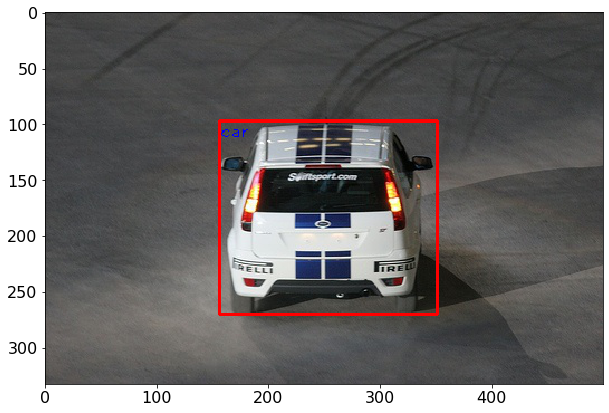

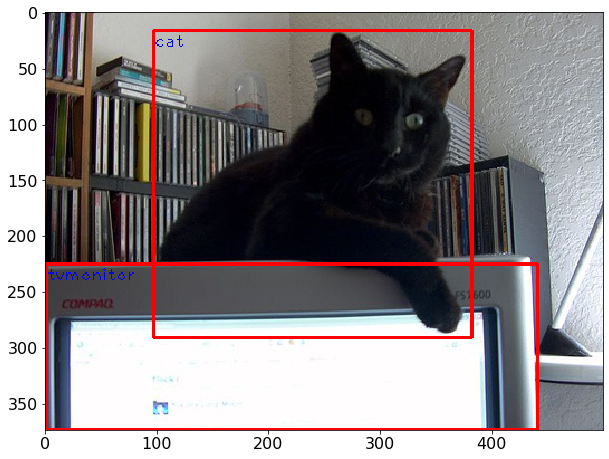

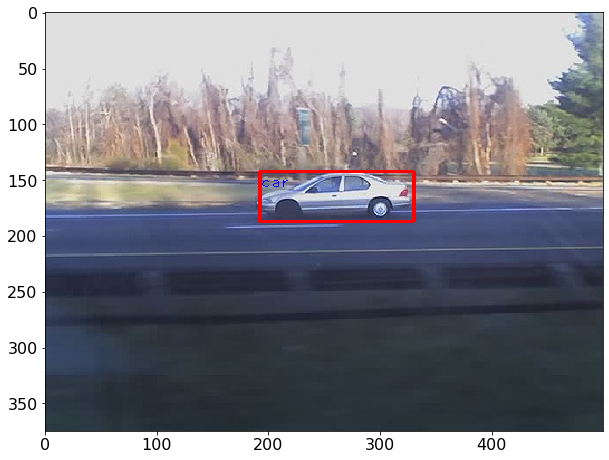

In [ ]:
# visualize GT boxes
for i in range(len(img_list)):
  valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
  eecs598.vis.detection_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

# Region Proposal Networks (RPN)
The first stage in a Faster R-CNN object detector is the *Region Proposal Network (RPN)*. The RPN classifies a set of anchors as either containing an object or not, and also regresses from the position of the anchor box to a region proposal.

The RPN is very similar to the single-stage detector we built in the previous notebook, except that it will not predict classification scores. We can therefore reuse many of the functions from the previous notebook in order to implement the RPN.

## Anchor
We will use the exact same set of anchors as in the single-stage detector from the previous notebook.

In [12]:
# Declare variables for anchor priors, a Ax2 Tensor where A is the number of anchors.
# Hand-picked, same as our two-stage detector.
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]], 
                           dtype=torch.float32, device='cuda')
print(anchor_list.shape)

torch.Size([9, 2])


## Activated (positive) and negative anchors
When training the RPN, we compare the anchor boxes with the ground-truth boxes in order to determine a ground-truth label for the anchor boxes -- should each anchor predict object or background?

We assign a positive label to two kinds of anchors:

(i) the anchor/anchors with the highest Intersection-overUnion (IoU) overlap with a ground-truth box, or

(ii) an anchor that has an IoU overlap higher than 0.7 with any ground-truth box. Note that a single ground-truth box may assign positive labels to multiple anchors.

Usually the second condition is sufficient to determine the positive samples; but we still adopt the first condition for the reason that in some rare cases the second condition may find no positive sample.

We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes. Anchors that are neither positive nor negative do not contribute to the training objective

We can implement anchor generation and matching to ground-truth by reusing the `GenerateGrid`, `GenerateAnchor`, `IoU`, and `ReferenceOnActivatedAnchors` functions from the previous notebook.

Run the following to check the implementation from A5-1 (with your IoU function). You should see errors on the order of 1e-7 or less.

In [13]:
reset_seed(0)

grid_list = GenerateGrid(w_list.shape[0])
anc_list = GenerateAnchor(anchor_list, grid_list)
iou_mat = IoU(anc_list, resized_box_list)
activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
  activated_anc_coord, negative_anc_coord = ReferenceOnActivatedAnchors(anc_list, resized_box_list, grid_list, iou_mat)

expected_GT_conf_scores = torch.tensor([0.74538743, 0.72793430, 0.71128041, 0.70029843,
                                        0.75670898, 0.76044953, 0.37116671, 0.37116671],
                                       dtype=torch.float32, device='cuda')
expected_GT_offsets = torch.tensor([[ 0.01633334,  0.11911901, -0.09431065,  0.19244696],
                                    [-0.03675002,  0.09324861, -0.00250307,  0.25213102],
                                    [-0.03675002, -0.15675139, -0.00250307,  0.25213102],
                                    [-0.02940002,  0.07459889, -0.22564663,  0.02898745],
                                    [ 0.11879997,  0.03208542,  0.20863886, -0.07974572],
                                    [-0.08120003,  0.03208542,  0.20863886, -0.07974572],
                                    [ 0.07699990,  0.28533328, -0.03459148, -0.86750042],
                                    [ 0.07699990, -0.21466672, -0.03459148, -0.86750042]],
                                   dtype=torch.float32, device='cuda')
expected_GT_class = torch.tensor([ 6,  7,  7,  7, 19, 19,  6,  6], dtype=torch.int64, device='cuda')
print('conf scores error: ', rel_error(GT_conf_scores, expected_GT_conf_scores))
print('offsets error: ', rel_error(GT_offsets, expected_GT_offsets))
print('class prob error: ', rel_error(GT_class, expected_GT_class))

number of pos proposals:  8
conf scores error:  0.0
offsets error:  4.294280664015343e-09
class prob error:  0.0


********************************************************************************
Activated (positive) anchors:
1 activated anchors!


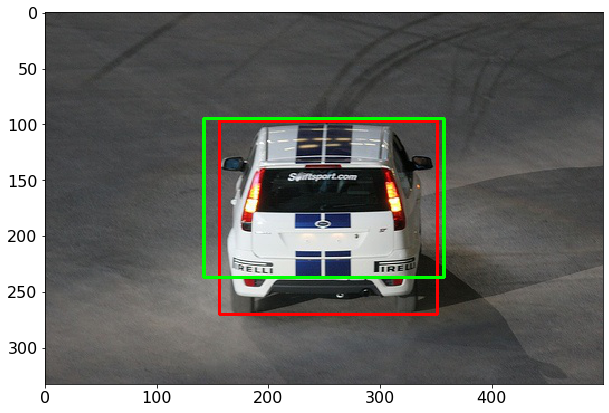

5 activated anchors!


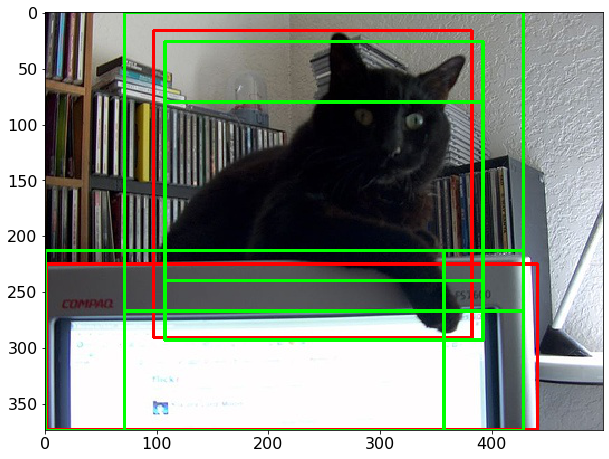

2 activated anchors!


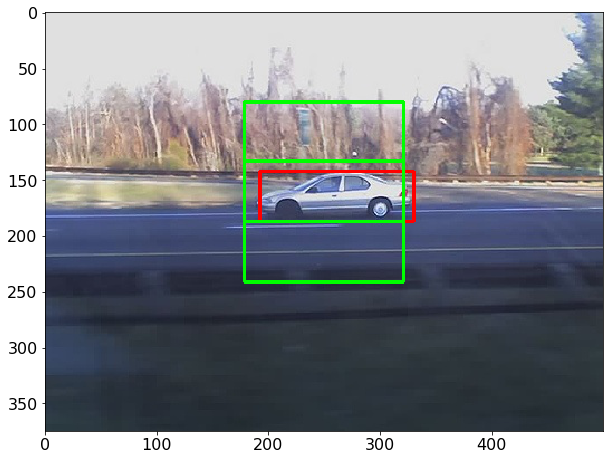

********************************************************************************
Negative anchors:
3 negative anchors!


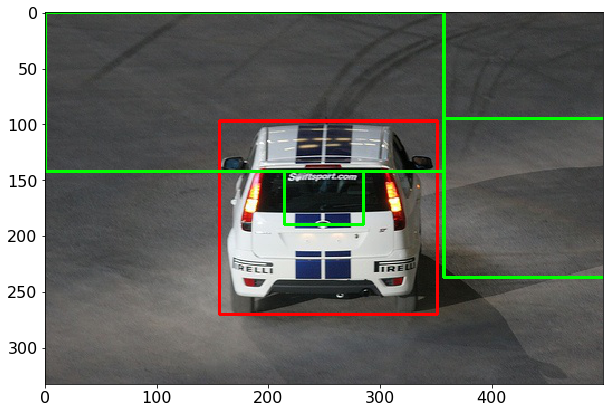

2 negative anchors!


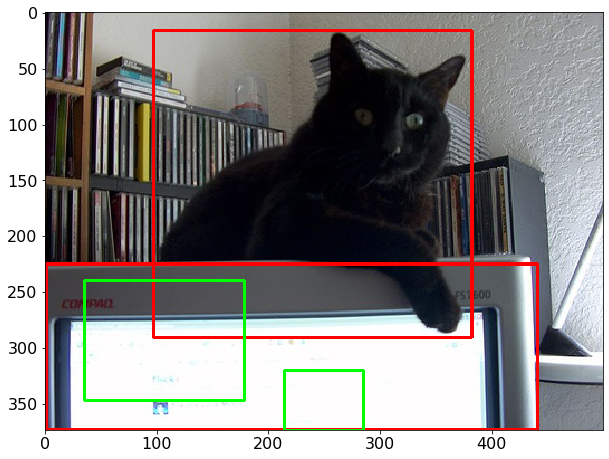

3 negative anchors!


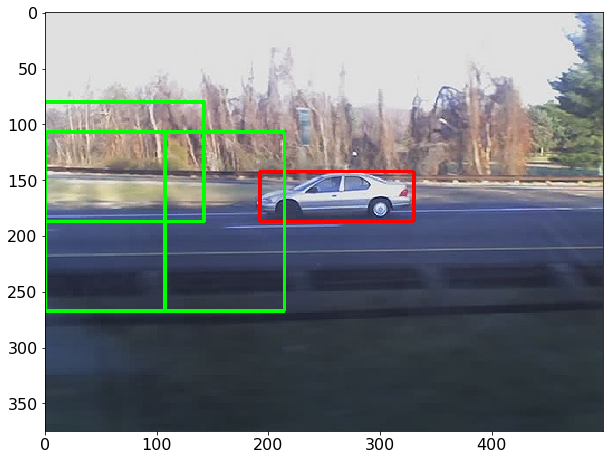

In [14]:
# visualize the activated anchors
anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1]))

print('*'*80)
print('Activated (positive) anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
  print('{} activated anchors!'.format(torch.sum(anc_ind_in_img)))
  eecs598.vis.detection_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(activated_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

print('*'*80)
print('Negative anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (negative_anc_ind >= idx * anc_per_img) & (negative_anc_ind < (idx+1) * anc_per_img)
  print('{} negative anchors!'.format(torch.sum(anc_ind_in_img)))
  eecs598.vis.detection_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(negative_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

## Proposal module
Similar to the Prediction Networks in A5-1, but for RPN you only need to predict the object proposal scores (from the *cls* layer) and bounding box offsets (from the *reg* layer), all of which are class-agnostic.

![pred_scores2](https://miro.medium.com/max/918/1*wB3ctS9WGNmw6pP_kjLjgg.png)

Note that here $k$ is essentially $A$. Image credit: Ren et al, "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks", NeurIPS 2015, https://arxiv.org/abs/1506.01497

Implement the forward pass of `ProposalNetwork` in `two_stage_detector.py`. Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [15]:
from two_stage_detector import ProposalModule

# sanity check
reset_seed(0)
prop_module = ProposalModule(1280, drop_ratio=0).to(dtype=torch.float32, device='cuda')
features = torch.linspace(-10., 10., steps=3*1280*7*7, dtype=torch.float32, device='cuda').view(3, 1280, 7, 7)
conf_scores, offsets, proposals = prop_module(features, activated_anc_coord, \
              pos_anchor_idx=activated_anc_ind, neg_anchor_idx=negative_anc_ind)

expected_conf_scores = torch.tensor([[-0.50843990,  2.62025023],
                                     [-0.55775326, -0.29983672],
                                     [-0.55796617, -0.30000290],
                                     [ 0.17819080, -0.42211828],
                                     [-0.51439995, -0.47708601],
                                     [-0.51439744, -0.47703803],
                                     [ 0.63225138,  2.71269488],
                                     [ 0.63224381,  2.71290708]],
                                    dtype=torch.float32, device='cuda')
expected_offsets = torch.tensor([[ 1.62754285,  1.35253453, -1.85451591, -1.77882397],
                                 [-0.33651856, -0.14402901, -0.07458937, -0.27201492],
                                 [-0.33671042, -0.14398587, -0.07479107, -0.27199429],
                                 [ 0.06847382,  0.21062726,  0.09334904, -0.02446130],
                                 [ 0.16506940, -0.30296192,  0.29626080,  0.32173073],
                                 [ 0.16507357, -0.30302414,  0.29625297,  0.32169008],
                                 [ 1.59992146, -0.75236654,  1.66449440,  2.05138564],
                                 [ 1.60008609, -0.75249159,  1.66474164,  2.05162382]], 
                                dtype=torch.float32, device='cuda')

print('conf scores error: ', rel_error(conf_scores[:8], expected_conf_scores))
print('offsets error: ', rel_error(offsets, expected_offsets))

conf scores error:  7.470063500812743e-07
offsets error:  1.4526211910238702e-06


## Loss Function
The confidence score regression loss is for both activated/negative anchors while the bounding box regression loss loss is for activated anchors only. 


The loss functions `ConfScoreRegression` and `BboxRegression` are both found in `two_stage_detection.py`. Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [16]:
from two_stage_detector import ConfScoreRegression, BboxRegression

conf_loss = ConfScoreRegression(conf_scores, features.shape[0])
reg_loss = BboxRegression(offsets, GT_offsets, features.shape[0])
print('conf loss: {:.4f}, reg loss: {:.4f}'.format(conf_loss, reg_loss))

loss_all = torch.tensor([conf_loss.data, reg_loss.data], dtype=torch.float32, device='cuda')
expected_loss = torch.tensor([8.55673981, 5.10593748], dtype=torch.float32, device='cuda')

print('loss error: ', rel_error(loss_all, expected_loss))

conf loss: 8.5567, reg loss: 5.1059
loss error:  5.572649968926904e-08


## RPN module
Implement Region Proposal Network. Should resemble the `SingleStageDetector` module from A5-1, but without the class prediction. Implement RPN in `two_stage_detector.py`. 

## RPN solver
In Faster R-CNN, the RPN is trained jointly with the second-stage network. However, to test our RPN implementation, we will first train just the RPN; this is basically a class-agnostic single-stage detector, that only classifies regions as object or background.

In [17]:
RPNSolver = DetectionSolver # the same solver as in YOLO

## RPN - Overfit small data
First we will overfit the RPN on a small subset of the PASCAL VOC 2007 dataset. After training you should see a loss around or less than 3.0.

lr:  0.001
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 0 / 200) loss: 30.3254 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 1 / 200) loss: 63.1495 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 2 / 200) loss: 24.5724 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 3 / 200) loss: 20.1772 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 4 / 200) loss: 19.0072 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 5 / 200) loss: 18.2219 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 6 / 200) loss: 17.6355 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 7 / 200) loss: 16.8202 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 8 / 200) loss: 16.6102 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 9 / 200) loss: 15.4856 time per epoch: 1.3s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 10 / 200) 

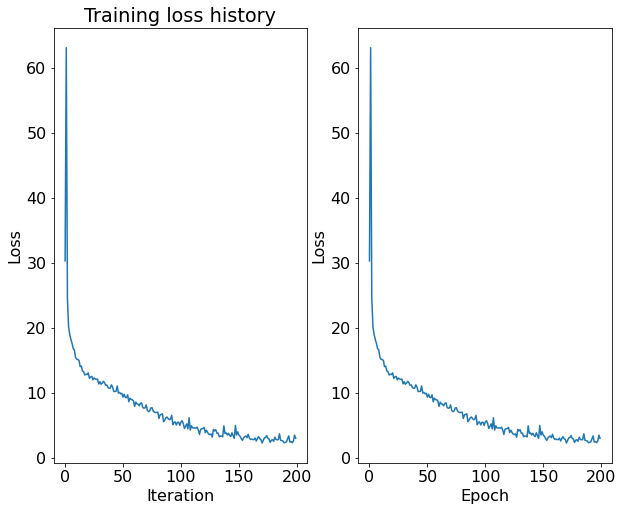

In [24]:
from two_stage_detector import RPN

# monitor the training loss
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-3]:
  print('lr: ', lr)
  rpn = RPN()
  RPNSolver(rpn, small_train_loader, learning_rate=lr, num_epochs=200, dtype=torch.float32, device='cuda')

## RPN - Inference
We will now visualize the predicted boxes from the RPN that we overfit to a small training sample. We will reuse the `DetectionInference` function from the previous notebook.

In [25]:
RPNInference = DetectionInference

In [27]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
# ignore the dummy object class (in blue) as RPN does not output class!
RPNInference(rpn, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32)

Output hidden; open in https://colab.research.google.com to view.

# Faster R-CNN

We have implemented the first half of Faster R-CNN, i.e., RPN, which is class-agnostic. Here, we briefly describe the second half Fast R-CNN.

Given the proposals or region of interests (RoI) from RPN, we warp each region from CNN activation map to a fixed size 2x2 by using [RoI Align](https://arxiv.org/pdf/1703.06870.pdf). Essentially, the RoI feature is determined by bilinear interpolation over the CNN activation map. We meanpool the RoI feature over the spatial dimension (2x2).

Finally, we classify the meanpooled RoI feature into class probabilities.

For simplicity, our two-stage detector here differs from a full Faster R-CNN system in a few aspects.
1. In a full implementation, the second stage of the network would predict a second set of offsets to transform the region proposal into a final predicted object bounding box. However we omit this for simplicity.
2. In a full implementation, the second stage of the network should be able to reject negative boxes -- in other words, if we want to predict C different object categories then the final classification layer of the second stage would predict a distribution over C+1 categories, with an extra one for background. We omit this, as it requires extra bookeeping in the second stage about which proposals are positive / negative; so for simplicity our second stage will only predict a distribution over C categories, and we will assume that the RPN has filtered out all background regions.

## RoI Align
We will use the `roi_align` function from `torchvision`. Usage see https://pytorch.org/docs/stable/torchvision/ops.html#torchvision.ops.roi_align

## Overfit small data

Implement the TwoStageDetector network in `two_stage_detector.py`. You can then test your implementation by overfitting the full Faster R-CNN network on a small subset of the training data. After training you should see a final loss less than 4.0.

In [28]:
from two_stage_detector import TwoStageDetector
# monitor the training loss

lr = 1e-3
detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200, dtype=torch.float32, device='cuda')

number of pos proposals:  50


ValueError: ignored

### Inference

In [ ]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, dtype=torch.float32, device='cuda')

## Train a net
Now it's time to train the full Faster R-CNN model on a larger subset of the the training data. We will train for 50 epochs; this should take about 30 minutes on a collab instance. You should see a total loss less than 3.0.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, batch_size=100) # a new loader

num_epochs = 50
lr = 5e-3
frcnn_detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(frcnn_detector, train_loader, learning_rate=lr, num_epochs=num_epochs, dtype=torch.float32, device='cuda')

After you've trained your model for 50 epochs, save it for submission. We reload it the weights and check the model accuracy as a sanity check.  

In [ ]:
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "frcnn_detector.pt")
torch.save(frcnn_detector.state_dict(), weights_path) # uncomment to save your checkpoint

frcnn_detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
frcnn_detector.load_state_dict(torch.load(weights_path)) # uncomment to load your previous checkpoint
DetectionEvaluater(frcnn_detector, train_loader, dtype=torch.float32, device='cuda')


### Inference

In [ ]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
DetectionInference(frcnn_detector, small_train_loader, small_dataset, idx_to_class, device='cuda', dtype=torch.float32)

## Evaluation
Compute mean Average Precision (mAP). Introduction on mAP see lecture slides (p46-57): https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture15.pdf


Run the following to evaluate your detector on the PASCAL VOC validation set. You should see mAP at around 16% or above.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
DetectionInference(frcnn_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32)
# DetectionInference(frcnn_detector, train_loader, train_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32) # uncomment to see training mAP
!cd mAP && python main.py

# Submit Your Work

After completing both notebooks for this assignment (`single_stage_detector_yolo.ipynb` and this notebook, `two_stage_detector_faster_rcnn.ipynb`), run the following cell to create a `.zip` file for you to download and turn in. **Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from eecs598.submit import make_a5_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = None
umid = None
make_a5_submission(GOOGLE_DRIVE_PATH, uniquename, umid)